In [1]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

warnings.filterwarnings('ignore')

import data_preprocessing
import context_handlers
import vit_pipeline
import EDCR_pipeline


############################################################################################################
##################################################vit_b_16##################################################
############################################################################################################


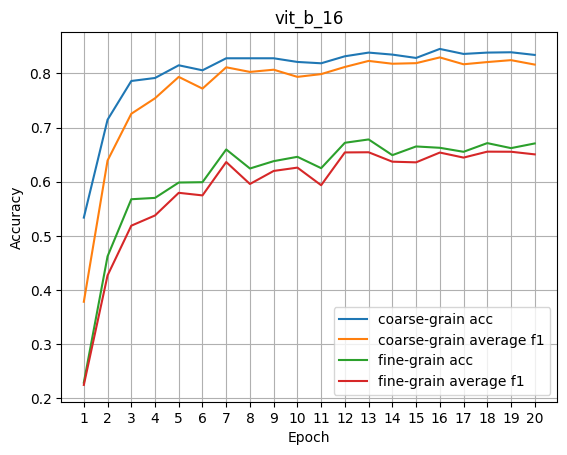


############################################################################################################
##################################################vit_b_32##################################################
############################################################################################################


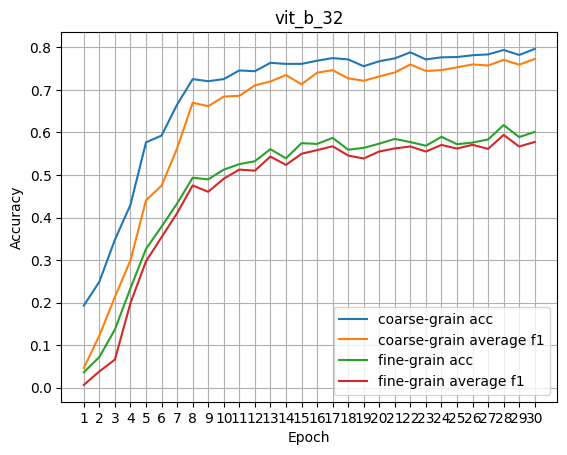


############################################################################################################
##################################################vit_l_16##################################################
############################################################################################################


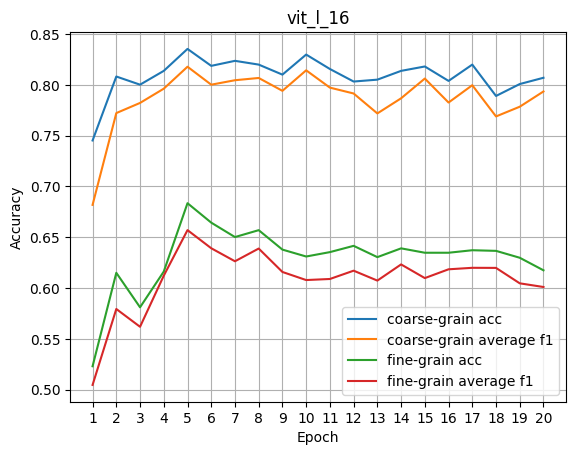


############################################################################################################
##################################################vit_l_32##################################################
############################################################################################################


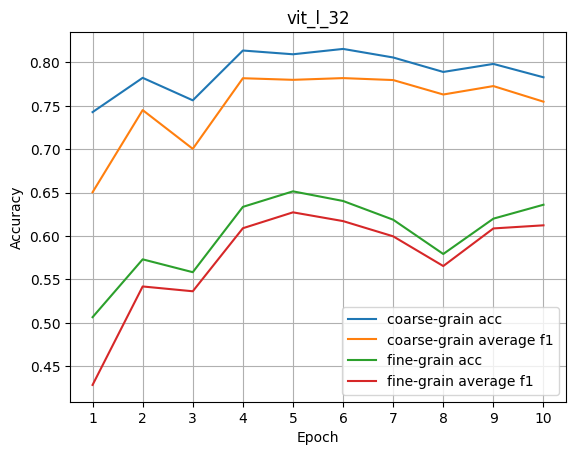

<Figure size 640x480 with 0 Axes>

In [2]:
def load_neural_results_from_path(path):
    test_data = {}
    test_fine_true = np.load(os.path.join(path, f'test_fine_true.npy'))
    test_coarse_true = np.load(os.path.join(path, f'test_coarse_true.npy'))
    
    for filename in os.listdir(path):
        test_match = re.match(pattern=rf'(.+?)_test_(.+?)_pred_lr(.+?)_e(\d+?).npy',
                                   string=filename)
        if test_match:
            model_name = test_match.group(1)
            granularity = test_match.group(2)
            lr_value = float(test_match.group(3))
            num_epochs = int(test_match.group(4)) + 1
        
            test_pred = np.load(os.path.join(path, filename))
            classes = data_preprocessing.fine_grain_classes \
                if granularity == 'fine' else data_preprocessing.coarse_grain_classes
            n_classes = len(classes)
            test_true = test_fine_true if granularity == 'fine' else test_coarse_true
        
            if model_name not in test_data:
                test_data[model_name] = {}
            if granularity not in test_data[model_name]:
                test_data[model_name][granularity] = {}
            if lr_value not in test_data[model_name][granularity]:
                test_data[model_name][granularity][lr_value] = {}
        
            test_data[model_name][granularity][lr_value][num_epochs] = \
                {'acc': accuracy_score(y_true=test_true, y_pred=test_pred), 
                 'cm': confusion_matrix(y_true=test_true, y_pred=test_pred),
                 'pre': precision_score(y_true=test_true, y_pred=test_pred, labels=range(n_classes), average='macro'),
                 'rec': recall_score(y_true=test_true, y_pred=test_pred, labels=range(n_classes), average='macro'),
                 'f1': f1_score(y_true=test_true, y_pred=test_pred, labels=range(n_classes), average='macro')}
    
    return test_data
    
def plot_verbose_test_metrics():
    for model_name, model_data in sorted(test_data.items()):
        print('\n' + '#'* (100 + len(model_name)))
        print('#'* 50 + f'{model_name}' + '#'* 50)
        print('#'* (100 + len(model_name)) + '\n')
        metric = 'Accuracy'
        
        with context_handlers.Plot():
            plt.title(f"{model_name}")
            plt.xlabel('Epoch')
            plt.ylabel(metric)
            
            for granularity, granularity_data in sorted(model_data.items()):
                for lr_value, lr_data in sorted(granularity_data.items()):
                    epochs, epoch_data = zip(*sorted(lr_data.items()))
                    plt.plot(epochs, [curr_data['acc'] for curr_data in epoch_data], label=f'{granularity}-grain acc')
                    plt.plot(epochs, [curr_data['f1'] for curr_data in epoch_data], label=f'{granularity}-grain average f1')
                    plt.xticks(np.arange(min(epochs), max(epochs)+1, 1)) # Set the x-axis ticks to be integers
        
            plt.legend()
            plt.grid()

test_data = load_neural_results_from_path(vit_pipeline.combined_results_path)
plot_verbose_test_metrics()

# Prior individual neural models metrics

In [3]:
individual_best_model = 'vit_b_16'
individual_fine_best_lr = '0.0001'
individual_coarse_best_lr = '0.0001'
individual_epoch_num = 10

individual_prior_fine_path = f'{individual_best_model}_test_pred_lr{individual_fine_best_lr}_e{individual_epoch_num - 1}_fine_individual.npy'
individual_prior_coarse_path = f'{individual_best_model}_test_pred_lr{individual_coarse_best_lr}_e{individual_epoch_num - 1}_coarse_individual.npy'

individual_prior_fine_data = np.load(os.path.join(vit_pipeline.individual_results_path, individual_prior_fine_path))
individual_prior_coarse_data = np.load(os.path.join(vit_pipeline.individual_results_path, individual_prior_coarse_path))

individual_true_fine_data = np.load(os.path.join(vit_pipeline.individual_results_path, 'test_true.npy'))
individual_true_coarse_data = np.load(os.path.join(vit_pipeline.individual_results_path, 'test_true_coarse.npy'))

individual_prior_fine_acc = accuracy_score(y_true=individual_true_fine_data, y_pred=individual_prior_fine_data)
individual_prior_fine_f1 = f1_score(y_true=individual_true_fine_data, y_pred=individual_prior_fine_data, labels=range(len(data_preprocessing.fine_grain_classes)), average='macro')
individual_prior_coarse_acc = accuracy_score(y_true=individual_true_coarse_data, y_pred=individual_prior_coarse_data)
individual_prior_coarse_f1 = f1_score(y_true=individual_true_coarse_data, y_pred=individual_prior_coarse_data, labels=range(len(data_preprocessing.coarse_grain_classes)), average='macro')

print(f'Individual models:\n' +
      '#' * 100 + '\n'
      f'Prior fine accuracy: {round(individual_prior_fine_acc * 100, 2)}%, '
      f'prior fine macro average f1: {round(individual_prior_fine_f1 * 100, 2)}%\n'
      f'prior coarse accuracy: {round(individual_prior_coarse_acc * 100, 2)}%, '
      f'prior coarse macro average f1: {round(individual_prior_coarse_f1 * 100, 2)}%\n')

vit_pipeline.print_num_inconsistencies(fine_labels=individual_prior_fine_data, 
                                       coarse_labels=individual_prior_coarse_data)

Individual models:
####################################################################################################
Prior fine accuracy: 66.63%, prior fine macro average f1: 64.16%
prior coarse accuracy: 81.06%, prior coarse macro average f1: 78.85%

Total prior inconsistencies 261/1621 (16.1%)


# Prior combined neural net metrics

In [4]:
combined_true_fine_data = np.load(os.path.join(vit_pipeline.combined_results_path, 'test_fine_true.npy'))
combined_true_coarse_data = np.load(os.path.join(vit_pipeline.combined_results_path, 'test_coarse_true.npy'))

# assert np.all(combined_true_fine_data == individual_true_fine_data)

combined_best_model = 'vit_b_16'
combined_best_lr = 0.0001
combined_epoch_num = 20

combined_prior_fine_path = f'{combined_best_model}_test_fine_pred_lr{combined_best_lr}_e{combined_epoch_num - 1}.npy'
combined_prior_coarse_path = f'{combined_best_model}_test_coarse_pred_lr{combined_best_lr}_e{combined_epoch_num - 1}.npy'

combined_prior_fine_data = np.load(os.path.join(vit_pipeline.combined_results_path, combined_prior_fine_path))
combined_prior_coarse_data = np.load(os.path.join(vit_pipeline.combined_results_path, combined_prior_coarse_path))

combined_prior_fine_acc = accuracy_score(y_true=combined_true_fine_data, y_pred=combined_prior_fine_data)
combined_prior_fine_f1 = f1_score(y_true=combined_true_fine_data, y_pred=combined_prior_fine_data, labels=range(len(data_preprocessing.fine_grain_classes)), average='macro')
combined_prior_coarse_acc = accuracy_score(y_true=combined_true_coarse_data, y_pred=combined_prior_coarse_data)
combined_prior_coarse_f1 = f1_score(y_true=combined_true_coarse_data, y_pred=combined_prior_coarse_data, labels=range(len(data_preprocessing.coarse_grain_classes)), average='macro')

print(f'Combined model:\n' +
      '#' * 100 + '\n'
      f'Prior fine accuracy: {round(combined_prior_fine_acc * 100, 2)}%, '
      f'prior fine macro average f1: {round(combined_prior_fine_f1 * 100, 2)}%\n'
      f'prior coarse accuracy: {round(combined_prior_coarse_acc * 100, 2)}%, '
      f'prior coarse macro average f1: {round(combined_prior_coarse_f1 * 100, 2)}%\n')

vit_pipeline.print_num_inconsistencies(fine_labels=combined_prior_fine_data, 
                                       coarse_labels=combined_prior_coarse_data)

Combined model:
####################################################################################################
Prior fine accuracy: 67.06%, prior fine macro average f1: 65.04%
prior coarse accuracy: 83.41%, prior coarse macro average f1: 81.62%

Total prior inconsistencies 64/1621 (3.95%)


# Combined EDCR Results

In [5]:
fine_folder = (f'{EDCR_pipeline.figs_folder}/main_fine_{combined_best_model}_lr{combined_best_lr}'
                  # f'_secondary_{EDCR_pipeline.secondary_model_name}_lr{EDCR_pipeline.secondary_lr}'
               )
coarse_folder = (f'{EDCR_pipeline.figs_folder}/main_coarse_{combined_best_model}_lr{combined_best_lr}'
                  # f'_secondary_{EDCR_pipeline.secondary_model_name}_lr{EDCR_pipeline.secondary_lr}'
                 )

post_fine_path = f'{fine_folder}/results.npy'
post_coarse_path = f'{coarse_folder}/results.npy'

post_fine_data = np.load(post_fine_path)
post_coarse_data = np.load(post_coarse_path)

post_fine_acc = accuracy_score(y_true=combined_true_fine_data, y_pred=post_fine_data)
post_fine_f1 = f1_score(y_true=combined_true_fine_data, y_pred=post_fine_data, labels=range(len(data_preprocessing.fine_grain_classes)), average='macro')
post_coarse_acc = accuracy_score(y_true=combined_true_coarse_data, y_pred=post_coarse_data)
post_coarse_f1 = f1_score(y_true=combined_true_coarse_data, y_pred=post_coarse_data, labels=range(len(data_preprocessing.coarse_grain_classes)), average='macro')

print(f'Post fine accuracy: {round(post_fine_acc * 100, 2)}%, '
      f'post fine macro average f1: {round(post_fine_f1 * 100, 2)}%\n'
      f'post coarse accuracy: {round(post_coarse_acc * 100, 2)}%, '
      f'post coarse macro average f1: {round(post_coarse_f1 * 100, 2)}%\n')

vit_pipeline.print_num_inconsistencies(fine_labels=post_fine_data,
                                       coarse_labels=post_coarse_data,
                                       prior=False)

FileNotFoundError: [Errno 2] No such file or directory: 'figs//main_fine_vit_b_16_lr0.0001/results.npy'

# BCE Loss

In [41]:
combined_bce_loss_fine_ground_truths = np.load(r'bce_loss/fine_grain_ground_truth.npy')
combined_bce_loss_fine_predictions = np.load(r'bce_loss/fine_grain_prediction.npy')

combined_bce_loss_fine_acc = accuracy_score(y_true=combined_bce_loss_fine_ground_truths,
                                            y_pred=combined_bce_loss_fine_predictions)
combined_bce_loss_fine_f1 = f1_score(y_true=combined_bce_loss_fine_ground_truths, 
                                     y_pred=combined_bce_loss_fine_predictions,
                                     labels=range(len(data_preprocessing.coarse_grain_classes), 
                                                  len(data_preprocessing.coarse_grain_classes) + 
                                                  len(data_preprocessing.fine_grain_classes)), 
                                     average='macro')

combined_bce_loss_coarse_ground_truths = np.load(r'bce_loss/coarse_grain_ground_truth.npy')
combined_bce_loss_coarse_predictions = np.load(r'bce_loss/coarse_grain_prediction.npy')

combined_bce_loss_coarse_acc = accuracy_score(y_true=combined_bce_loss_coarse_ground_truths,
                                              y_pred=combined_bce_loss_coarse_predictions)
combined_bce_loss_coarse_f1 = f1_score(y_true=combined_bce_loss_coarse_ground_truths, 
                                       y_pred=combined_bce_loss_coarse_predictions,
                                       labels=range(len(data_preprocessing.coarse_grain_classes)), 
                                       average='macro')

print(f'BCE loss fine accuracy: {round(combined_bce_loss_fine_acc * 100, 2)}%, '
      f'BCE loss fine macro average f1: {round(combined_bce_loss_fine_f1 * 100, 2)}%\n'
      f'BCE loss coarse accuracy: {round(combined_bce_loss_coarse_acc * 100, 2)}%, '
      f'BCE loss coarse macro average f1: {round(combined_bce_loss_coarse_f1 * 100, 2)}%\n')

BCE loss fine accuracy: 64.03%, BCE loss fine macro average f1: 61.75%
BCE loss coarse accuracy: 81.92%, BCE loss coarse macro average f1: 80.11%


In [31]:
# get_num_inconsistencies(fine_predictions=combined_bce_loss_fine_predictions, 
#                         coarse_predictions=combined_bce_loss_coarse_predictions)

KeyError: 29